# Goal
The goal of this notebook is to make a much easier to use mini-dataset out of the Chest X-Ray collection. The idea is to have something akin to MNIST or Fashion MNIST for medical images. For this we will preprocess, normalize and down-scale the images. Additionally all of the images will be packed into a single hdf5 to make it easier to use them for other tasks

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from cv2 import imread, createCLAHE # read and equalize images
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
all_xray_df = pd.read_csv('/home/vivek/workspace/NIH-dataset/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'NIH-dataset', 'data', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
30003,00007816_005.png,No Finding,5,7816,65,F,AP,2928,2544,0.139,0.139,NaN,../NIH-dataset/data/images/00007816_005.png
104003,00027745_000.png,Infiltration,0,27745,82,M,AP,3056,2544,0.139,0.139,NaN,../NIH-dataset/data/images/00027745_000.png
56825,00014125_055.png,No Finding,55,14125,28,M,AP,3056,2544,0.139,0.139,NaN,../NIH-dataset/data/images/00014125_055.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

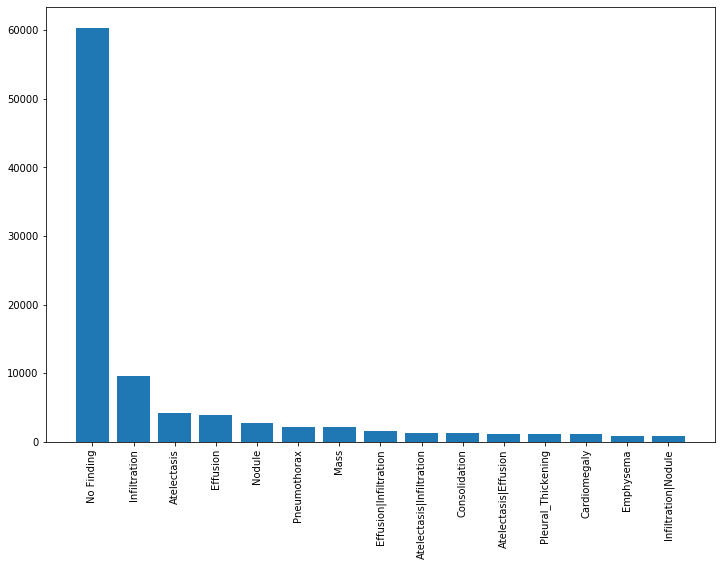

In [16]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [17]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('All Labels', all_labels)
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels ['' 'Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38017,00009995_004.png,,4,9995,62,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15530,00004066_001.png,,1,4066,31,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89049,00022104_000.png,Infiltration|Nodule,0,22104,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


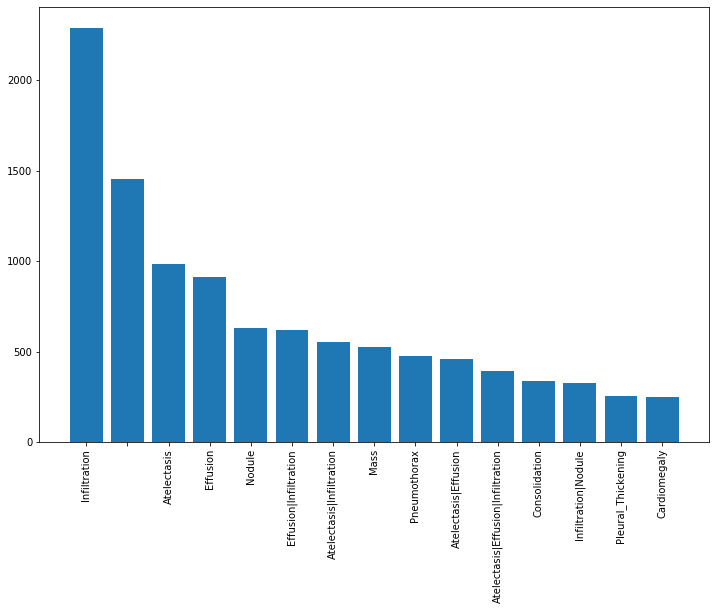

In [18]:
# since we can't have everything make a nice subset
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 1e-1
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(18000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Create an HDF5
Here we create an HDF5 with all the relevant label information inside. We can add the images later

In [19]:
import h5py
from tqdm import tqdm

def write_df_as_hdf(out_path,
                    out_df,
                    compression='gzip'):
    with h5py.File(out_path, 'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(), 0)
                try:
                    h.create_dataset(k, data=s_data, compression=
                    compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k, data=s_data.astype(np.string_),
                                         compression=compression)
                    except TypeError as e2:
                        print('%s could not be added to hdf5, %s' % (
                            k, repr(e), repr(e2)))
            except ValueError as e:
                print('%s could not be created, %s' % (k, repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                warn('Input shapes: {}'.format(all_shape))

In [20]:
write_df_as_hdf('chest_xray.h5', all_xray_df)

  0%|          | 0/27 [00:00<?, ?it/s]/home/vivek/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 27/27 [00:00<00:00, 40.88it/s]


In [21]:
# show what is inside
with h5py.File('chest_xray.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (18000,) float64
Cardiomegaly (18000,) float64
Consolidation (18000,) float64
Edema (18000,) float64
Effusion (18000,) float64
Emphysema (18000,) float64
Fibrosis (18000,) float64
Finding Labels (18000,) |S94
Follow-up # (18000,) int64
Height] (18000,) int64
Hernia (18000,) float64
Image Index (18000,) |S16
Infiltration (18000,) float64
Mass (18000,) float64
Nodule (18000,) float64
OriginalImagePixelSpacing[x (18000,) float64
OriginalImage[Width (18000,) int64
Patient Age (18000,) int64
Patient Gender (18000,) |S1
Patient ID (18000,) int64
Pleural_Thickening (18000,) float64
Pneumonia (18000,) float64
Pneumothorax (18000,) float64
Unnamed: 11 (18000,) float64
View Position (18000,) |S2
path (18000,) |S43
y] (18000,) float64


# Preprocessing Images
Since the images all look a bit different we use a standard CLAHE algorithm to equalize the histograms in them. We then downscale to 128x128 (256x256 would be better but that seems to push at the limits of what Kaggle allows). This is enough to see very vague detail and possibly

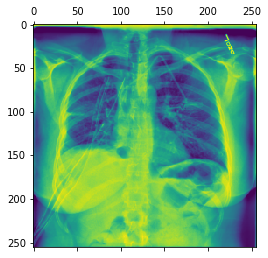

In [23]:
from skimage.transform import resize
OUT_DIM = (256, 256)
def imread_and_normalize(im_path):
    clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    img_data = clahe_tool.apply(img_data)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    return np.expand_dims(n_img, -1)


test_img = imread_and_normalize(all_xray_df['path'].values[0])
plt.matshow(test_img[:,:,0])

In [24]:
%%time
# time for 100 images
pre_read_tiles = np.stack(all_xray_df.sample(100)['path'].map(imread_and_normalize).values,0)

CPU times: user 6.28 s, sys: 21 ms, total: 6.3 s
Wall time: 4.65 s


5.5s for 100 images means 1.71 hours for the whole dataset which is more time than kaggle gives us, so we have to trim, also writing out the full data takes up too much space (output <= 1gb)

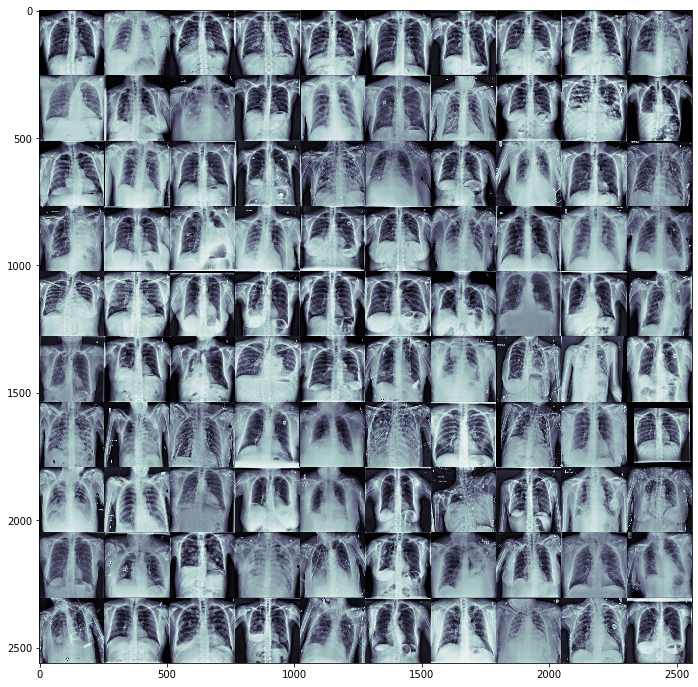

In [25]:
# might as well show-em if we have em
from skimage.util import montage
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
ax1.imshow(montage(pre_read_tiles[:,:,:,0]), cmap = 'bone')
fig.savefig('overview.png', dpi = 300)

In [26]:
# preallocate output
out_image_arr = np.zeros((all_xray_df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)
if False:
    # a difficult to compress array for size approximations
    out_image_arr = np.random.uniform(0, 255,
                                  size = (all_xray_df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [27]:
for i, c_path in enumerate(tqdm(all_xray_df['path'].values)):
    out_image_arr[i] = imread_and_normalize(c_path)

100%|██████████| 18000/18000 [14:10<00:00, 21.16it/s]


In [30]:
# append the array
with h5py.File('chest_xray.h5', 'a') as h5_data:
    h5_data.create_dataset('images', data = out_image_arr, compression = None) # compression takes too long
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (18000,) float64
Cardiomegaly (18000,) float64
Consolidation (18000,) float64
Edema (18000,) float64
Effusion (18000,) float64
Emphysema (18000,) float64
Fibrosis (18000,) float64
Finding Labels (18000,) |S94
Follow-up # (18000,) int64
Height] (18000,) int64
Hernia (18000,) float64
Image Index (18000,) |S16
Infiltration (18000,) float64
Mass (18000,) float64
Nodule (18000,) float64
OriginalImagePixelSpacing[x (18000,) float64
OriginalImage[Width (18000,) int64
Patient Age (18000,) int64
Patient Gender (18000,) |S1
Patient ID (18000,) int64
Pleural_Thickening (18000,) float64
Pneumonia (18000,) float64
Pneumothorax (18000,) float64
Unnamed: 11 (18000,) float64
View Position (18000,) |S2
images (18000, 256, 256, 1) uint8
path (18000,) |S43
y] (18000,) float64


In [31]:
print('Output File-size %2.2fMB' % (os.path.getsize('chest_xray.h5')/1e6))

Output File-size 1180.21MB
